In [2]:
import tensorflow as tf
print('tensorflow version: {}'.format(tf.__version__))
import numpy as np
import matplotlib.pyplot as plt

tensorflow version: 1.15.0


# 1. K-means [9 pt.]

## 1.1 Learning K-means

Distance function for K-means

In [3]:
# Distance function for K-means
def distance_func(X, mu):
    """ Inputs:
          X: is an NxD matrix (N observations and D dimensions)
          mu: is an KxD matrix (K means and D dimensions)

        Output:
          pair_dist: is the squared pairwise distance matrix (NxK)
    """
    # TODO
    # expand to the same dimension to use broadcast
    X = tf.expand_dims(X, 1) # N×1×D
    mu = tf.expand_dims(mu, 0) # 1×K×D
    pair_dist = tf.reduce_sum(tf.square(tf.subtract(X, mu)), 2) # Reduces input_tensor along the axis 2 (D axis); In this instance, it's calculating the MSE for the distance
    return pair_dist


Load Data

In [31]:
# Loading data
data = np.load('data2D.npy')
''' 
'data2D.npy'
10000 2-dim datapoints
max:3.9326602149671155
min:-4.904299993422375
'''

#data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data) # num_pts = 10000, dim = 2

# For Validation set
is_valid = True
if is_valid:
    valid_batch = int(num_pts / 3.0)
    np.random.seed(45689)
    rnd_idx = np.arange(num_pts)
    np.random.shuffle(rnd_idx)
    val_data = data[rnd_idx[:valid_batch]]
    data = data[rnd_idx[valid_batch:]]


Build graph

Implemented the Adam gradient descent optimizer

In [5]:
def buildGraphKMeans(data, data_dim, lr, K):
    data_points = tf.placeholder(tf.float32, (None, data_dim))

    # Initialize cluster centers by directing selecting K points from the train_data
    centers = tf.Variable(tf.cast(tf.slice(tf.random_shuffle(data), [0, 0], (K, -1)), dtype=tf.float32), dtype=tf.float32) # directly slice from the shuffled dataset
    
    # Used Adam optimizer to optimize, not recalculating based on the new mu (K-mean algorithm in the textbook)
    optim = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.9, beta2=0.99, epsilon=1e-5)

    # Loss is the distance between datapoint and their closest cluster center
    loss = tf.reduce_sum(tf.reduce_min(distance_func(data_points, centers), axis=1))
    optim = optim.minimize(loss)

    return data_points, centers, optim, loss

Plot scatterplot

In [6]:
def plotScatter(datapts, centers, K, colors, min_val_loss):
    ## Data processing
    frequency = np.bincount(colors) # colors is an array of the colors of datapoints; bincount() returns occurrences of each value in array of non-negative ints,
    # In this way, we extract each of the cluster that have some datapoints in it
    index = np.nonzero(frequency)[0] # filter out the index that do not have any color in it, the dimension of index might not be the same as the dimension of K
    datapts_in_colour = zip(index, frequency[index]) # used in the for loop

    ## Plot the scatterplot
    fig = plt.figure(figsize=(8, 5))
    
    if K == 1:
        plt.title("1 Cluster")
    else:
        plt.title("{} Clusters".format(K))

    # plot each cluster
    for i, color_set in enumerate(datapts_in_colour):
        percentage = "Cluster {} {}%".format(color_set[0] + 1, round((color_set[1] / len(colors)) * 100, 1))
        plt.scatter(datapts[i][:, 0], datapts[i][:, 1], s=4, label=percentage) # s: size, c: color, alpha: transparency

    # plot the center of each cluster with a star
    plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=100, c='black')

    # report the percentage of data of each cluster
    fig.text(0.5, 0.01, "Validation loss: " + str(min_val_loss), ha='center', fontsize=12)

    plt.legend()
    plt.show()


In [7]:
def plot_loss(K, train_loss, val_loss):
    fig = plt.figure(figsize=(8, 5))
    plt.title("Loss of {} clusters".format(K))
    plt.plot(train_loss, label="Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.legend()
    fig.text(0.5, 0.01, "Final training loss: " + str(round(train_loss[-1], 2)) + "   |   Final validation loss: " + str(round(val_loss[-1], 2)), ha='center', fontsize=12)
    plt.show()


Find center


Train K-means

In [8]:
def trainKMeans(K, lr, epochs=10, plot=True):
    X, mu, optim, loss = buildGraphKMeans(data, dim, lr, K)

    train_loss = []
    val_loss = []
    cluster_data = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) # initialize the place holders

        for epoch in range(epochs):
            centers, losses, _ = sess.run([mu, loss, optim], feed_dict={X: data}) # use feed_dict for the place holders
            train_loss.append(losses / len(data))

            valid_center, valid_loss, _ = sess.run([mu, loss, optim], feed_dict={X: val_data})
            val_loss.append(valid_loss / len(val_data))

    # get the color (closed cluster center) of each datapoints, color is a N×1 array
    colours = tf.arg_min(distance_func(tf.cast(data,tf.float32), centers), 1).eval(session=tf. compat. v1. Session()) # use .eval(session=tf. compat. v1. Session()) to convert to numpy array, otherwise will have problem with plotscatter data processing
    
    # collect the datapoint that "belongs" to each cluster
    for i in range(K):
        cluster_data.append(data[colours == i])

    if (plot):
        # scatterplot
        plotScatter(cluster_data, centers, K, colours, round(val_loss[-1], 2))

    # loss plot
    plot_loss(K, train_loss, val_loss)

    return train_loss, val_loss


### 1.1.1 
For the dataset data2D.npy, set K = 3 and ﬁnd the K-means clusters $\mu$ by minimizing the L($\mu$) using the gradient descent optimizer.

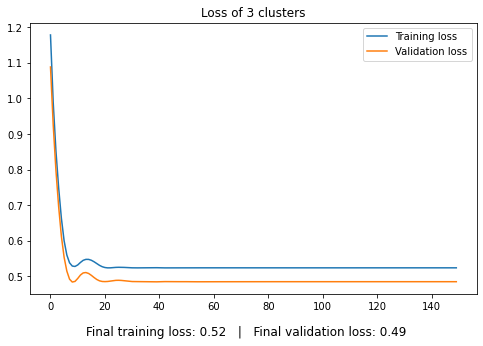

In [32]:
train_loss, val_loss = trainKMeans(3, 0.1, epochs=150, plot=False)

### 1.1.2

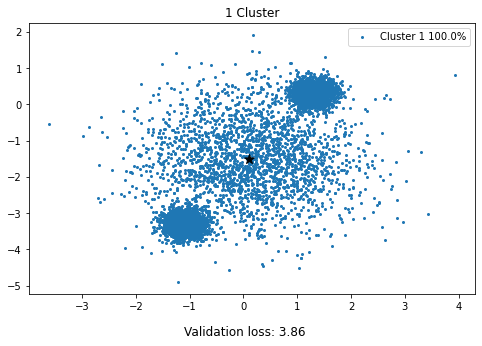

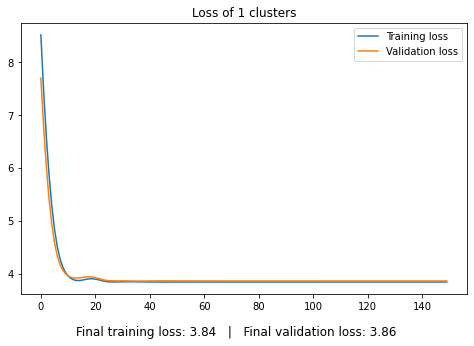

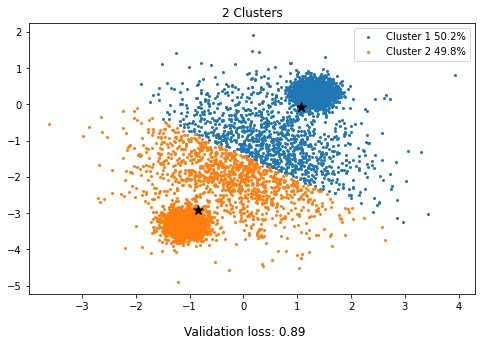

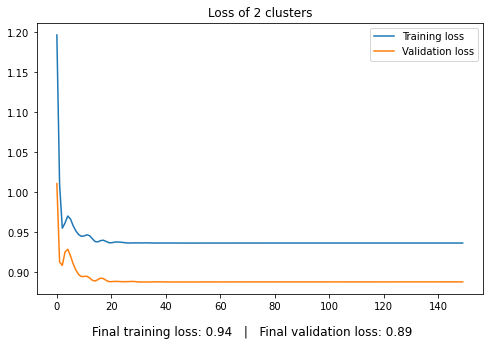

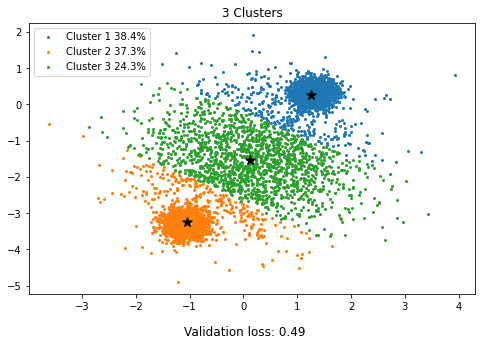

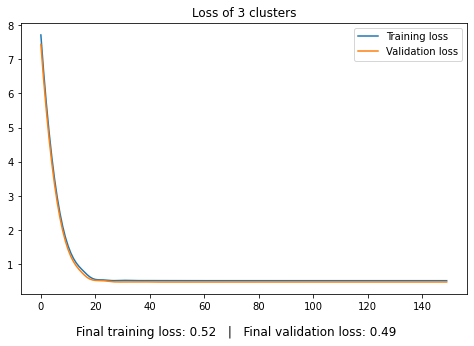

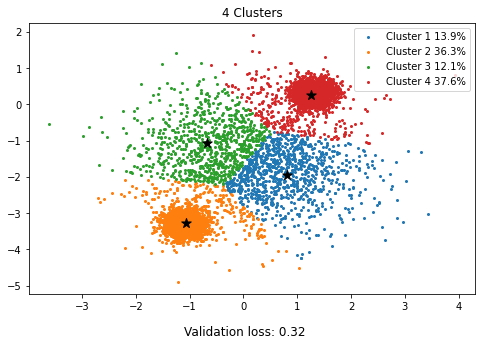

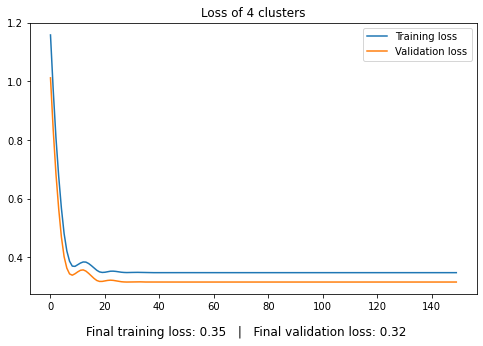

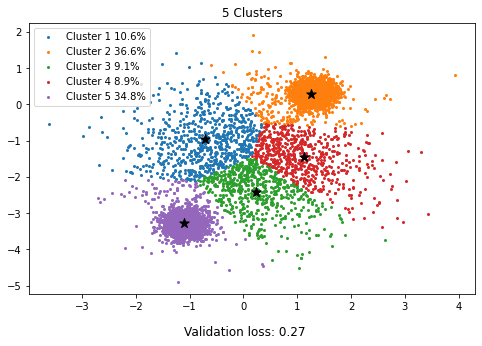

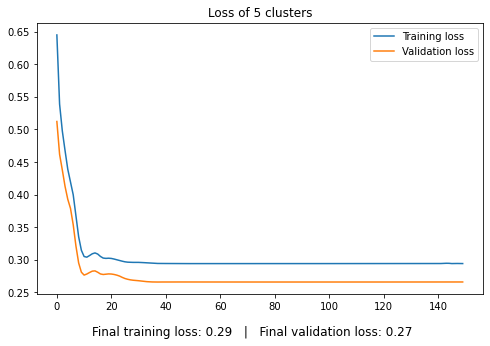

In [10]:
val_loss_with_k = []
for k in range(5):
    train_loss, val_loss = trainKMeans(k + 1, 0.1, epochs=150)
    val_loss_with_k.append(val_loss[-1])


In [12]:
def plot_val_loss_with_k(val_loss_with_k, k_range):
    plt.figure(figsize=(8, 5))
    idx = list(range(1, k_range + 1))
    plt.plot(idx, val_loss_with_k)
    plt.xticks(idx)
    plt.title("Validation Loss vs Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Validation Loss")
    plt.grid(True)


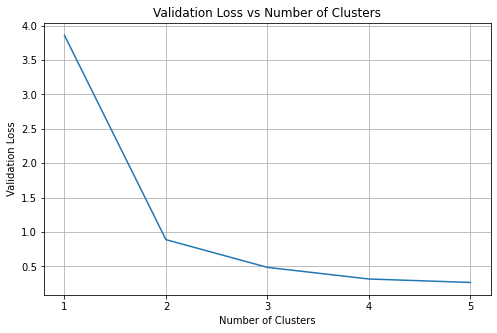

In [13]:
plot_val_loss_with_k(val_loss_with_k, 5)

Based on the scatter plots, comment on the best number of clusters to use.

In [11]:
# The best number of clusters to use is 5.
# Simply from the validation loss from the last iteration (see figure above), using cluster of 5 gives us the lowest validation loss.
# Also, from our tuition, making the cluster center more distributed will reduce the distance from each datapoint to its closest cluster center.
# Through optimization on the original randomly selected cluster center, we can get a more distributed distribution of cluster centers.

# 2. Mixtures of Gaussians [16 pt.]

## 2.1 The Gaussian cluster mode [7 pt.]

Helper functions 
1. reduce_logsumexp provided
2. logsoftmax

In [14]:
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
    """Computes the sum of elements across dimensions of a tensor in log domain.

       It uses a similar API to tf.reduce_sum.

    Args:
      input_tensor: The tensor to reduce. Should have numeric type.
      reduction_indices: The dimensions to reduce. 
      keep_dims: If true, retains reduced dimensions with length 1.
    Returns:
      The reduced tensor.
    """
    max_input_tensor1 = tf.reduce_max(input_tensor, reduction_indices, keep_dims=keep_dims)
    max_input_tensor2 = max_input_tensor1
    if not keep_dims:
        max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)

    return tf.log(
        tf.reduce_sum(
            tf.exp(input_tensor - max_input_tensor2), # use - to convert to negative exponential to avoid overflow
            reduction_indices,
            keep_dims=keep_dims)) + max_input_tensor1


def logsoftmax(input_tensor):
    # computes the probability of falling into each cluster from the total k clusters given the input_tensor
    """Computes normal softmax nonlinearity in log domain.

       It can be used to normalize log probability.
       The softmax is always computed along the second dimension of the input Tensor.     

    Args:
      input_tensor: Unnormalized log probability.
    Returns:
      normalized log probability.
    """
    return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)


### 2.1.1

A multivariate (d-variable) gaussian distribution is given by:

$\begin{aligned}
N(\mathbf{x}|\boldsymbol{\mu}^k, \sigma^{k^2})&=\frac{1}{\left(2\pi\right)^{\frac{d}{2}}|\Sigma|^{\frac{1}{2}}} \exp(-\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^{T}\Sigma^{-1}(\mathbf{x} - \boldsymbol{\mu}))
\end{aligned}$ 

Since different data dimensions are independent, we have covariance = 0. And since the variables have the same standard deviation, $\sigma^{k}$, the covariance matrix $\Sigma$ is a diagonal matrix with $\sigma^{k^2}$ on its main diagonal and 0 elsewhere. This simplifies the equation above to:

$\begin{aligned}
N(\mathbf{x}|\boldsymbol{\mu}^k, \sigma^{k^2})&=\frac{1}{\left(2\pi\sigma^{k^2}\right)^{\frac{d}{2}}} \exp(-\frac{1}{2}\frac{|| \mathbf{x}-\boldsymbol{\mu} ||^2_2}{\sigma^{k^2}})
\end{aligned}$

After applying the logarithm, we get:

$\begin{aligned}
\log(N(\mathbf{x}|\boldsymbol{\mu}^k, \sigma^{k^2}))&=\log(\frac{1}{\left(2\pi\sigma^{k^2}\right)^{\frac{d}{2}}} \exp(-\frac{1}{2}\frac{|| \mathbf{x}-\boldsymbol{\mu} ||^2_2}{\sigma^{k^2}})) \\
&= \log(\frac{1}{(2\pi\sigma^{k^2})^{\frac{d}{2}}}) - \frac{1}{2} \frac{|| \mathbf{x}-\boldsymbol{\mu} ||^2_2}{\sigma^{k^2}} \\
&= -\frac{d}{2}\log(2\pi\sigma^{k^2}) - \frac{1}{2} \frac{|| \mathbf{x}-\boldsymbol{\mu} ||^2_2}{\sigma^{k^2}} \\
&= -\frac{1}{2}(d\times\log(2\pi\sigma^{k^2}) + \frac{|| \mathbf{x}-\boldsymbol{\mu} ||^2_2}{\sigma^{k^2}})
\end{aligned}$

In [15]:
def log_gauss_pdf(X, mu, sigma):
    """ Inputs: 
            X: N X D
            mu: K X D
            sigma: K X 1, is not sigma in the formula, but standard deviation

        Outputs:
            log Gaussian PDF (N X K)
    """
    first_term = tf.cast(X.shape[1], tf.float32) * tf.math.log(2 * np.pi * sigma) # have to cast dimension type to float type
    second_term = tf.transpose(tf.transpose(distance_func(X, mu)) / sigma)
    return -0.5 * (tf.transpose(first_term) + second_term)


### 2.1.2

Using Baye's rule:

$\begin{aligned}
P(z=k|\textbf{x})&=\frac{P(\textbf{x}|z=k)P(z=k)}{P(\textbf{x})} \\
&=\frac{P(\textbf{x}|z=k)P(z=k)}{\sum_{i=1}^{K}P(\textbf{x}|z=i)P(z=i)}
\end{aligned}$

Using log rules:

$\begin{aligned}
\log(P(z=k|\textbf{x}))&=\log(\frac{P(\textbf{x}|z=k)P(z=k)}{P(\textbf{x})}) \\
&=\log(P(\textbf{x}|z=k)) + \log(P(z=k)) - \log(\sum_{i=1}^{K}P(\textbf{x}|z=i)P(z=i))
\end{aligned}$

Simplifying:

$\begin{aligned}
\log(P(z=k|\textbf{x}))&=\log(N(\textbf{x}|\mu^k, \sigma^{k^2})) + \log(\pi^k) - \log(\sum_{i=1}^{K} e^{\log(P(\textbf{x}|z=i)) + \log(P(z=i))})
\end{aligned}$

In [16]:
def log_posterior(log_PDF, log_pi):
    # computes the log probability of the cluster variable z given the data vector x
    """ Inputs:
            log_PDF: log Gaussian PDF N X K 
            log_pi: K X 1 weight of each gaussian variable

        Outputs
            log_post: N X K
    """
    
    # TODO
    log_pi = tf.transpose(log_pi)
    log_sum = reduce_logsumexp(log_PDF + log_pi, keep_dims=True)
    return  log_PDF + log_pi - log_sum

Comment on why it is important to use the log-sum-exp function instead of using tf.reduce_sum.

In [17]:
# Because the function reduce_logsumexp computes the sum of elements across dimensions of a tensor in log domain but tf.reduce_sum calculate in the integer domain.
# As our calculation above suggest the last term is calculated in the log domain, where the formula just fit the calculation of reduce_logsumexp

In [18]:
def buildGraphGMM(data, data_dim, K, lr, div):
    data_points = tf.placeholder(tf.float32, (None, data_dim))

    # Initialize cluster centers by directing selecting K points from the train_data
    centers = tf.Variable(tf.cast(tf.slice(tf.random_shuffle(data), [0, 0], (K, -1)), dtype=tf.float32), dtype=tf.float32) # cast K data from the 0 idx

    # Initialize the standard deviation of each function from a gaussian distribution
    # Make it exponential instead of square to deal with constraint (as mentioned in the pdf)
    sigma = tf.Variable(tf.random_normal((K, 1), stddev=div), dtype=tf.float32)
    sigma = tf.exp(sigma)

    # The weights of each distribution, pi_k is represented by a softmax function
    pi = tf.Variable(tf.random_normal((K, 1), stddev=div), dtype=tf.float32)
    pi = tf.squeeze(logsoftmax(pi))

    # The loss function we are trying to minimize
    log_pdf = log_gauss_pdf(data_points, centers, sigma)
    loss = reduce_logsumexp(log_pdf + pi, 1, keep_dims=True)
    loss = -1 * tf.reduce_sum(loss)

    # Use Adam optimizer as before
    optim = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.9, beta2=0.99, epsilon=1e-5)
    optim = optim.minimize(loss)

    # MIE: maximum likelihood estimate; predict which cluster using softmax activation
    cluster = tf.nn.softmax(log_posterior(log_pdf, pi))
    cluster = tf.argmax(cluster, axis=1)

    return data_points, centers, sigma, pi, optim, loss, cluster


In [19]:
def trainGMM(K, lr, stddve, epochs=100, plot=True):
    X, MU, sigma, pi, optim, loss, classify = buildGraphGMM(data, dim, K, lr, stddve)

    train_loss, val_loss, train_cluster, cluster_data = ([] for i in range(4))

    ## Training
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(epochs):
            centers, losses, cluster, _ = sess.run([MU, loss, classify, optim], feed_dict={
                X: data})
            train_loss.append(losses / len(data))

            valid_center, valid_loss, _, __ = sess.run([MU, loss, classify, optim], feed_dict={X: val_data})
            val_loss.append(valid_loss / len(val_data))

        for i in range(K):
            cluster_data.append(data[cluster == i])

    ## Ploting
    if (plot):
        plotScatter(cluster_data, centers, K, cluster, round(val_loss[-1], 2))

    plot_loss(K, train_loss, val_loss)

    return train_loss, val_loss


## 2.2

### 2.2.1

The loss plot and the cluster center it learnt is shown below

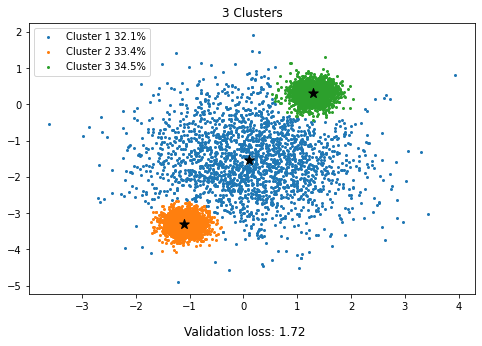

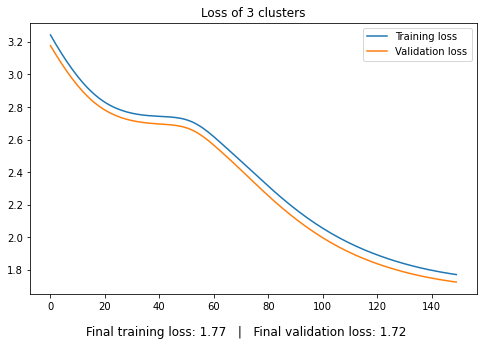

In [33]:
train_loss, val_loss = trainGMM(3, lr=0.01, stddve=0.05, epochs=150)

### 2.2.2

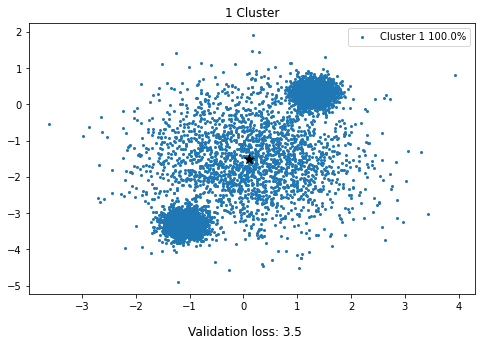

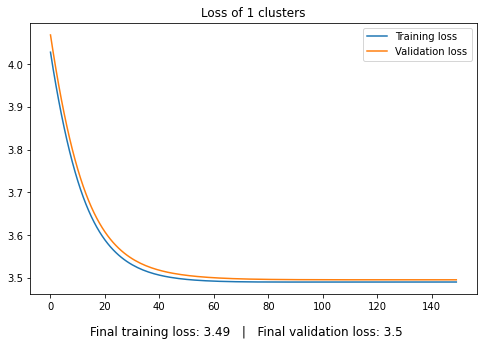

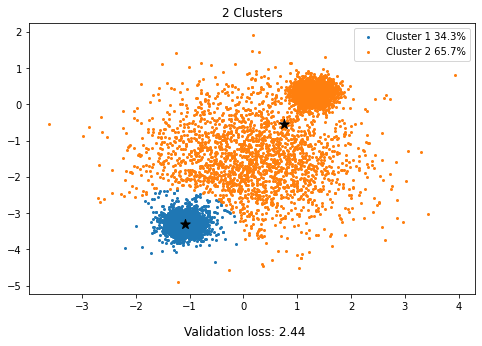

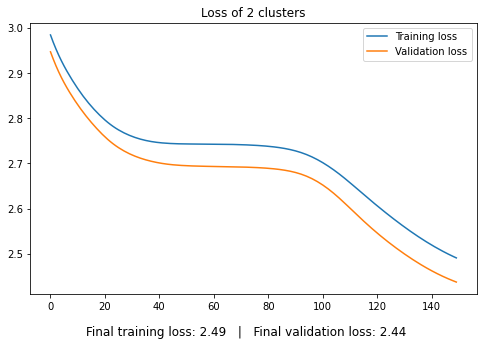

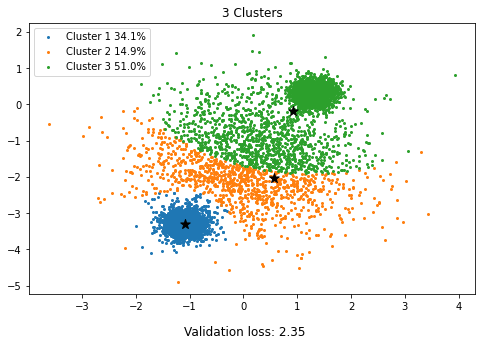

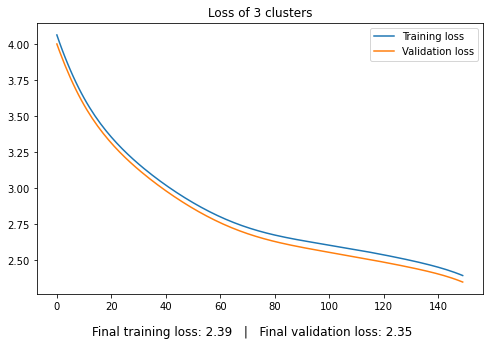

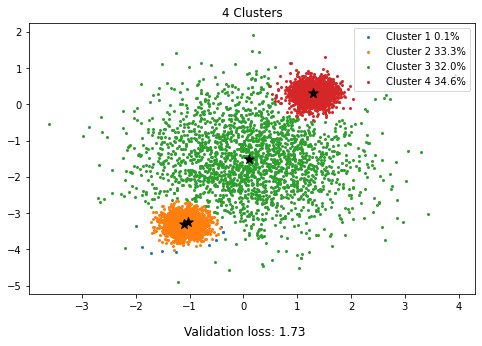

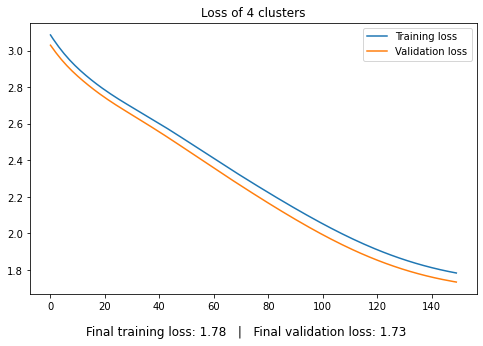

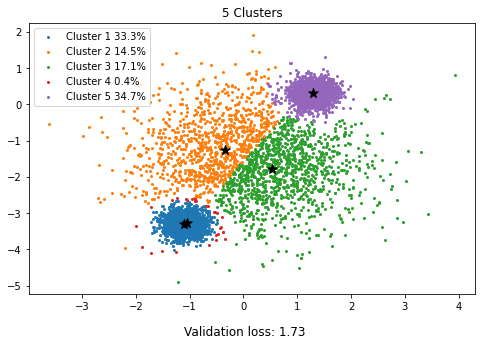

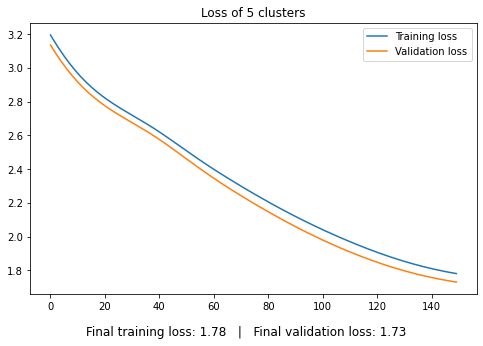

In [34]:
val_loss_with_k = []
for k in range(5):
    train_loss, val_loss = trainGMM(k + 1, lr=0.01, stddve=0.05, epochs=150)
    val_loss_with_k.append(val_loss[-1])

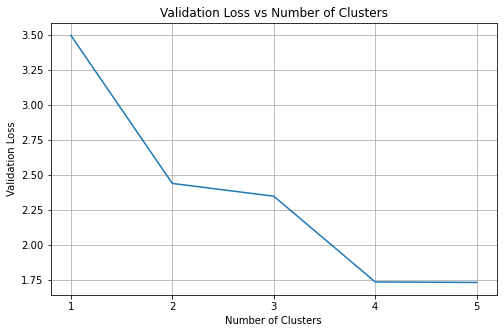

In [35]:
plot_val_loss_with_k(val_loss_with_k, 5)

Explain which value of K is best, based on the validation loss.

In [23]:
# From the plot above, we can discover from the validation loss that cluster = 4 is the best.
# This is the slight different case with Kmeans, in which increasing the number of cluster obviously decrease the validation loss. But we can see here and from many previous try that cluster above 3 doesn't bring obvious improvement.

### 2.2.3

In [36]:
# Loading data
data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data) # num_pts = 10000, dim = 2

# For Validation set (moved elsewhere)
is_valid = True
if is_valid:
    valid_batch = int(num_pts / 3.0)
    np.random.seed(45689)
    rnd_idx = np.arange(num_pts)
    np.random.shuffle(rnd_idx)
    val_data = data[rnd_idx[:valid_batch]]
    data = data[rnd_idx[valid_batch:]]

In [37]:
def plot_val_loss_with_idx(val_loss_with_k, idx, type):
    plt.figure(figsize=(8, 5))
    plt.plot(idx, val_loss_with_k)
    plt.xticks(idx)
    plt.title("{} Validation Loss vs Number of Clusters".format(type))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Validation Loss")
    plt.grid(True)

GMM

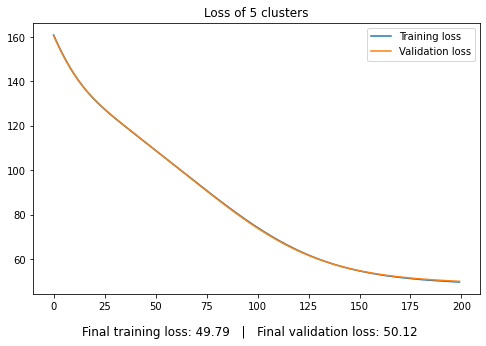

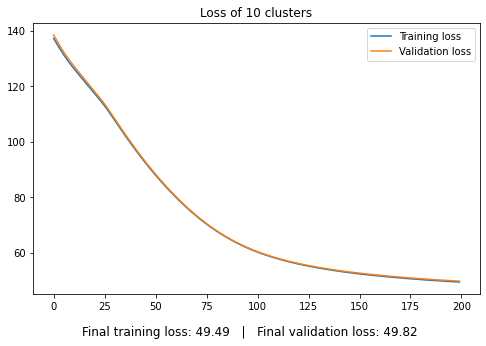

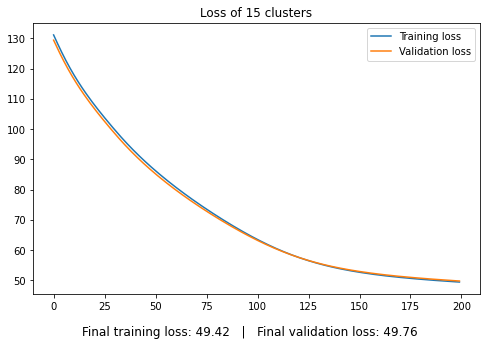

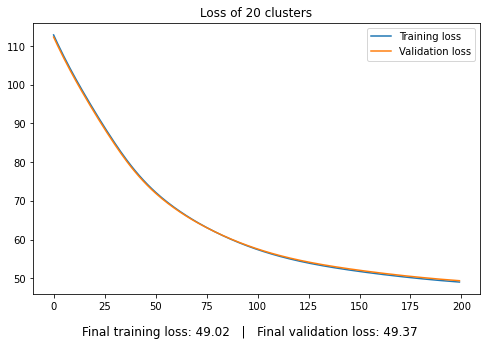

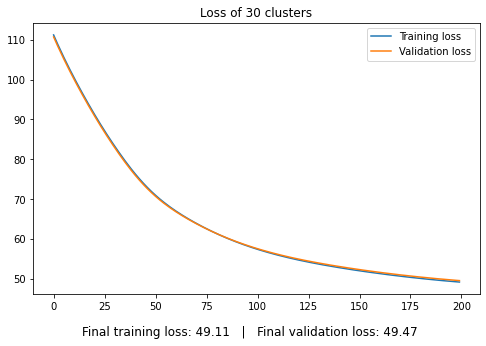

In [38]:
num_clusters = [5, 10, 15, 20, 30]

val_loss_with_k = []
for k in num_clusters:
    train_loss, val_loss = trainGMM(k, lr=0.01, stddve=0.05, epochs=200, plot=False)
    val_loss_with_k.append(val_loss[-1])

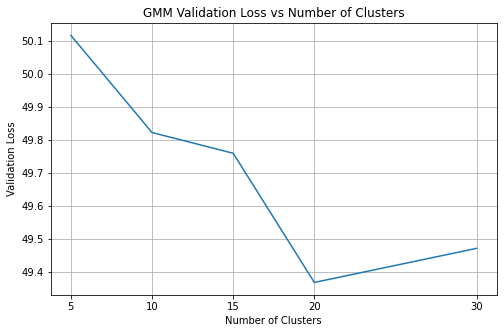

In [39]:
plot_val_loss_with_idx(val_loss_with_k, num_clusters, 'GMM')

Kmeans

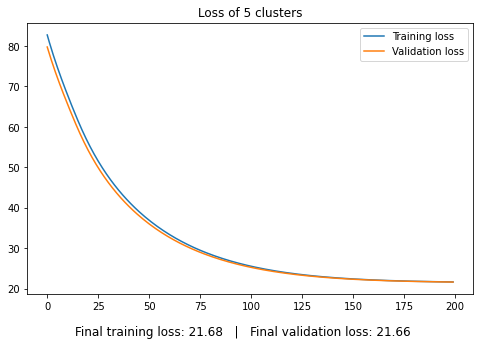

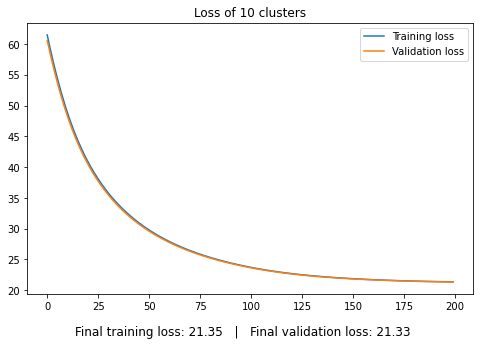

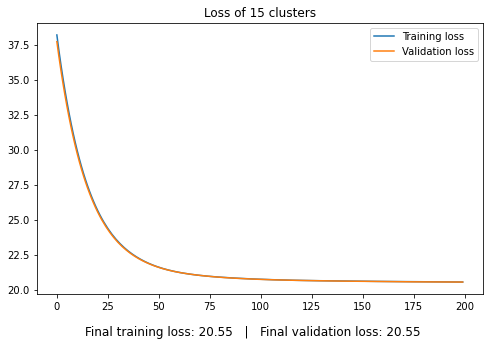

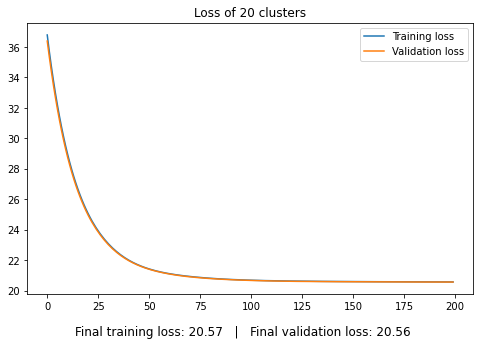

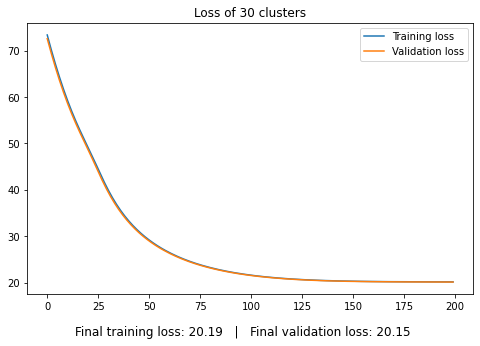

In [40]:
num_clusters = [5, 10, 15, 20, 30]

val_loss_with_k = []
for k in num_clusters:
    train_loss, val_loss = trainKMeans(k, lr=0.01, epochs=200, plot=False)
    val_loss_with_k.append(val_loss[-1])

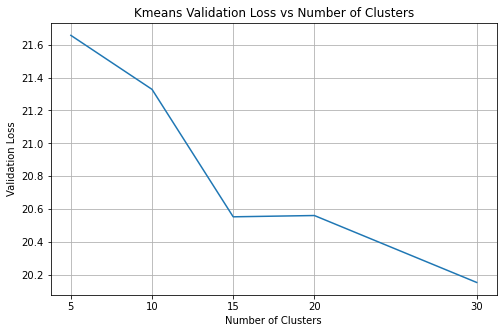

In [41]:
plot_val_loss_with_idx(val_loss_with_k, num_clusters, 'Kmeans')

Comment on how many clusters you think are within the dataset by looking at the MoG validation loss and K-means validation loss.

In [ ]:
# I think it's hard to tell how many clusters there are. But looking at the two line above, we can get somple range of the number of clusters. From the GMM line chart, we see that the validation loss rise between 20 and 30 clusters. And the real number of clusters should be less than 20. 
# Also, as increasing the number of clusters would probability decrease the loss, the reasonable number of cluster may be much less than 20. 5 clusters may be a reasonable choice. 

Compare the learnt results of K-means and MoG.

In [ ]:
# The MoG plot converges earlier than K-means.
# As we can see from the two line charts, the MoG converges at approximately 20 clusters, while K-means' loss continues to decrease as the number of cluster increases.
# MoG is a more comprehensive solution to unsupervised learning, as the true number of clusters can't be greater than 20.